### Install Dependency

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install statsmodels

### Imports

In [263]:
#Python 3.8.13
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
from colorama import Fore
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Retrive data from .csv file

In [264]:
#Read data
csv_file = 'CIC.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df

,Year,Quarter,Total
0,1968,Q4,2131
1,1969,Q1,2162
2,1969,Q2,2144
3,1969,Q3,2190
4,1969,Q4,2261
...,...,...,...
210,2021,Q2,592566
211,2021,Q3,592153
212,2021,Q4,606030
213,2022,Q1,621073


### Require Dataframe with format (datetime , Time Series data) only

In [265]:
#Data cleaning
df['Date'] = df['Year']
for index in df.index:
    if (df['Quarter'][index] == 'Q1'):
        df['Date'][index] = str(df['Year'][index]) + '-03-01'
    elif (df['Quarter'][index] == 'Q2'):
        df['Date'][index] = str(df['Year'][index]) + '-06-01'
    elif (df['Quarter'][index] == 'Q3'):
        df['Date'][index] = str(df['Year'][index]) + '-09-01'
    elif (df['Quarter'][index] == 'Q4'):
        df['Date'][index] = str(df['Year'][index]) + '-12-01'
#convert floating point to int then to str
# df['Date'] = df['Year'].astype(str) + '-' + (df['月'].astype(int)).astype(str) + '-01'
# df.head()

### Data Cleaning

In [266]:
#Data cleaning
df_clean = df.loc[:,['Date','Total']]
df_clean.rename(columns={'Date':'date','Total':'total'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df.dropna(inplace=True)
df_clean.tail()

,date,total
210,2021-06-01,592566
211,2021-09-01,592153
212,2021-12-01,606030
213,2022-03-01,621073
214,2022-06-01,626793


In [267]:
#Subseting data, Leave some data for forcecasting
df_clean.set_index('date',inplace=True)
start_year, end_year = 2000, 2021
start_date = pd.to_datetime(str(start_year) + '-01-01')
end_date = pd.to_datetime(str(end_year) +'-01-01')
df_clean = df_clean[start_date:end_date]
df.dropna(inplace=True)
df_train = df_clean.copy()
df_clean.tail()

,total
date,
2019-12-01,529859
2020-03-01,540675
2020-06-01,549580
2020-09-01,584663
2020-12-01,572688


### Useful function for printing out test output

In [279]:
#Print Graph
def plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear):
    plt.figure(figsize=(10,4))
    plt.plot(dataframe[column])
    plt.title(plottitle, fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] <= 0.05):
        print(Fore.GREEN + f'It is stationary (p-value: {adfuller_result[1]})')
    else:
        print(Fore.LIGHTRED_EX + f'It is non-stationary (p-value: {adfuller_result[1]})')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(10,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1):
    ADFtest(dataframe, column)
    plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plt.rcParams.update({'figure.figsize':(10,4)})
    plot_acf(dataframe[column],  alpha=.05, lags=30)
    plot_pacf(dataframe[column],  alpha=.05, method='ywm',lags=30)   
    seasonDecomposer(dataframe, column, models, periods)

#Check all stationarity after log and differencing
def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(dataframe[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] <= 0.05):
            print(Fore.GREEN + f'{data} : stationary (p-value: {adfuller_result[1]})')
        else:
            print(Fore.LIGHTRED_EX + f'{data} : non-stationary (p-value: {adfuller_result[1]})')

#Ljung-Box test for serial correlation of standardized residuals
def lgBoxResult(result):
    test_stat = result[0][0]
    p_value = result[0][1]
    for i in range(len(test_stat)):
        print(Fore.RESET + f'At Lag: {i}, Test statistic: {test_stat[i]}, p-value:{p_value[i]}')
        if (p_value[i] <= 0.05):
            print(Fore.LIGHTRED_EX + f'p-value =< 0.05, Null hypothesis is rejected, there is serial correlation.')
        else:
            print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.')
        print(Fore.RESET + '------------------------------------------------------------------------------------------')

#Shapiro-Wilk normality test
def shapiro_test(np_array):
    '''
    https://github.com/scipy/scipy/blob/v1.9.3/scipy/stats/_morestats.py#L1727-L1802
    The chance of rejecting the null hypothesis when it is true is close to 5%
    regardless of sample size.
    '''
    shapiro_result = shapiro(np_array)
    print('-------------------------------Shapiro-Wilk normality test Result------------------------------')
    print(f'Test statistic: {shapiro_result.statistic}')
    print(f'p-value       : {shapiro_result.pvalue}')
    if (shapiro_result.pvalue <= 0.05):
        print(Fore.LIGHTRED_EX + f'p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.')
    else:
        print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, data was drawn from a normal distribution.')
    print(Fore.RESET + '-----------------------------------------------------------------------------------------------')

def plotStdResid(std_resid_array):
    plt.figure(figsize=(10,4))
    plt.plot(std_resid_array)
    plt.title('Standardized Residuals Sequence', fontsize=20)
    plt.ylabel('Standardized Residuals', fontsize=16) 
    

### Original Time Series data plot with stationarity, seasonality check

ADF statistic: 2.3005788095207613
p-value      : 0.9989555501982509
Critical values:
  1%,  -3.526004646825607
Critical values:
  5%,  -2.9032002348069774
Critical values:
  10%,  -2.5889948363419957
It is non-stationary (p-value: 0.9989555501982509)


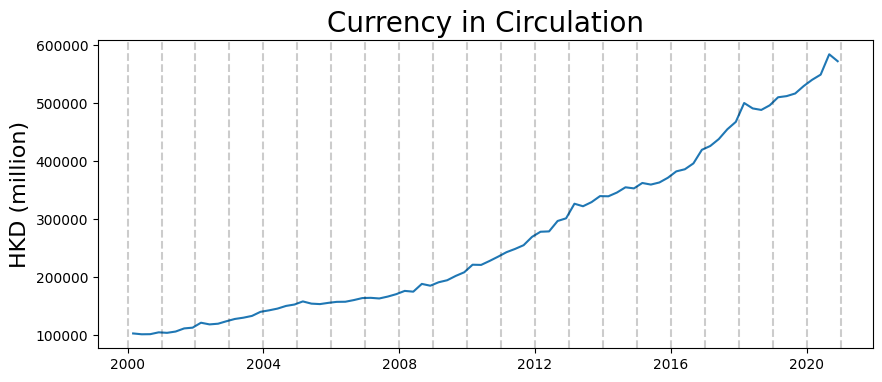

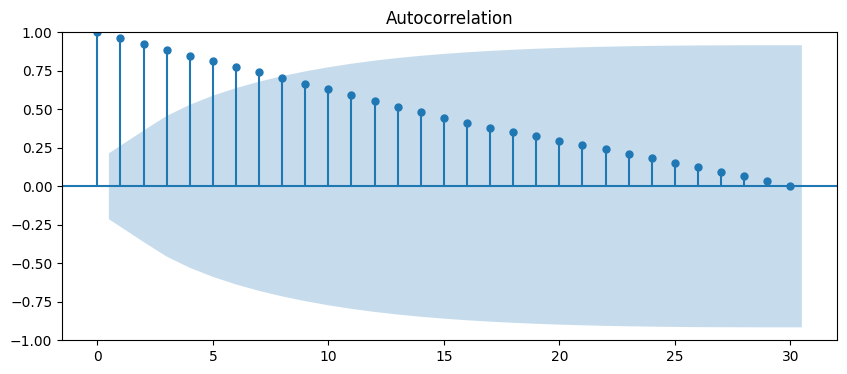

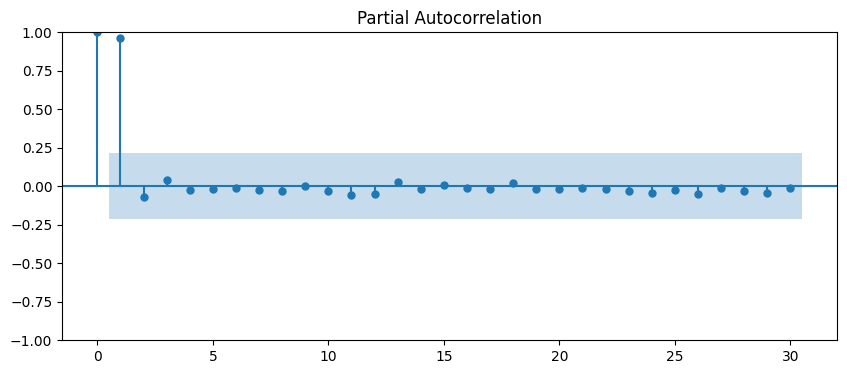

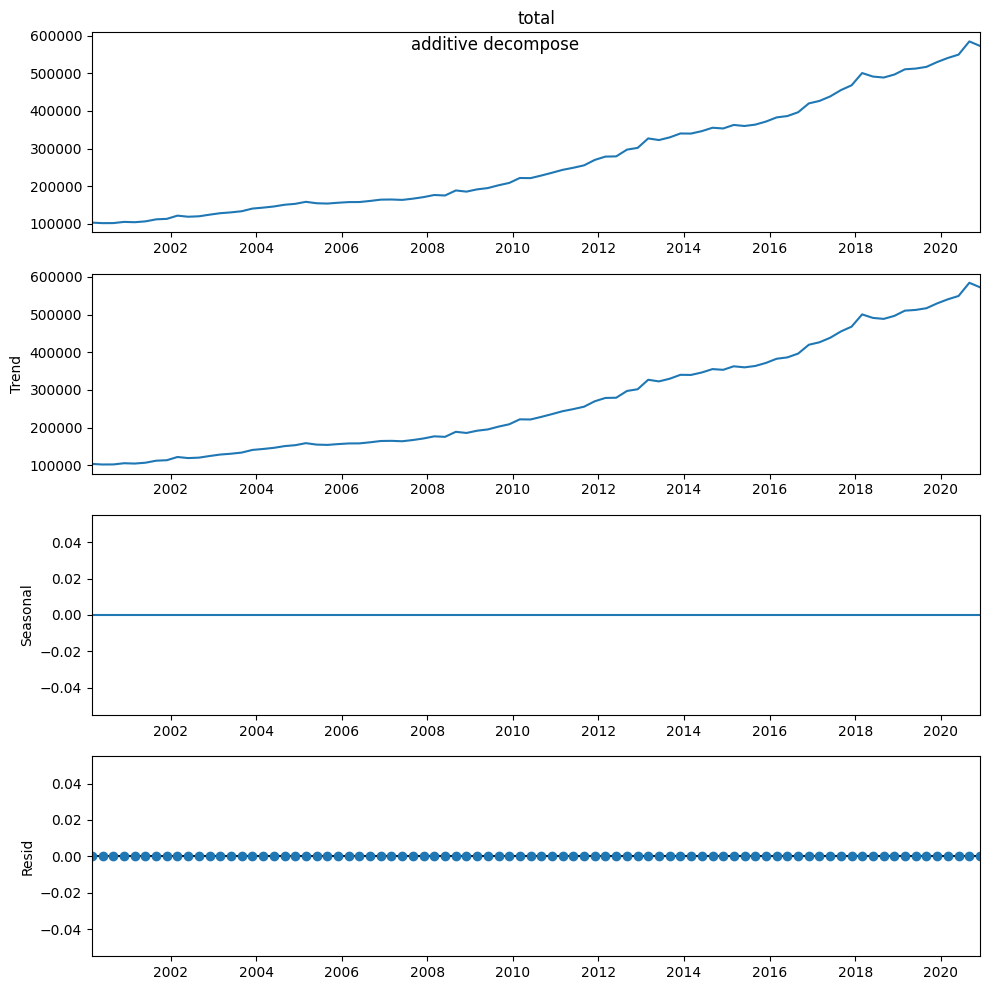

In [269]:
plotAll(df_clean, 'total', 'Currency in Circulation', 'HKD (million)', start_year, end_year+1, models='additive', periods=1)

### Calculating all the possible Time Series data transformation

Please run this before running the below graph plotting

In [270]:
#All stationarity result after log and differencing
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2']
allStationarity(df_clean,'total')

total : non-stationary (p-value: 0.9989342613922461)
after_log : non-stationary (p-value: 0.9637298199444321)
difference_1 : non-stationary (p-value: 0.8762016187138905)
difference_2 : stationary (p-value: 4.744927411162505e-05)
log_difference_1 : stationary (p-value: 7.934405137618791e-22)
log_difference_2 : stationary (p-value: 5.713968867963828e-12)


### Graph ploting with stationartiy, seasonality check

In [ ]:
#Log Transformation
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1)
plotAll(df_clean, 'after_log', 'CPI Over Time (log)', 'CPI', start_year, end_year+1, models='additive', periods=1)

In [ ]:
#First order differencing
plotAll(df_clean, 'difference_1', 'CPI Over Time (log, d=1)', 'CPI', start_year, end_year+1, models='additive', periods=1)

ADF statistic: -4.830892024137794
p-value      : 4.744927411162505e-05
Critical values:
  1%,  -3.5274258688046647
Critical values:
  5%,  -2.903810816326531
Critical values:
  10%,  -2.5893204081632653
It is stationary (p-value: 4.744927411162505e-05)


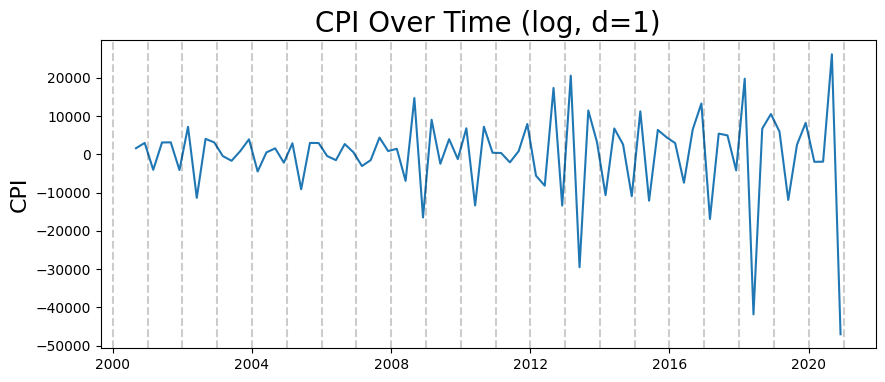

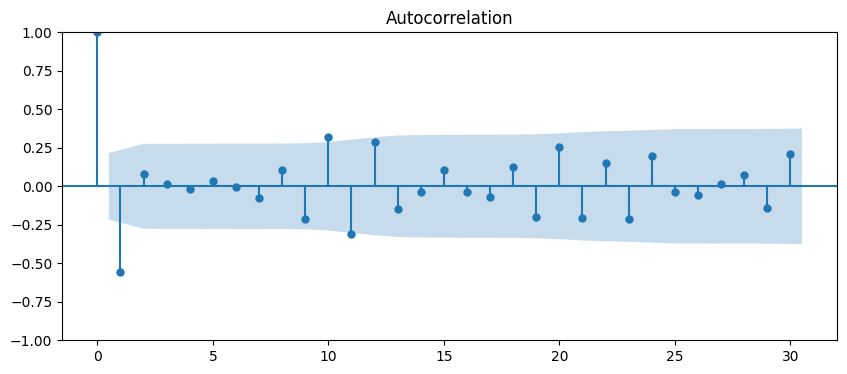

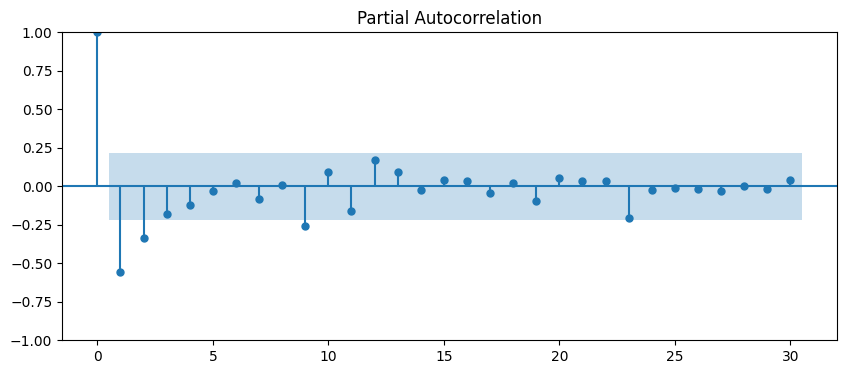

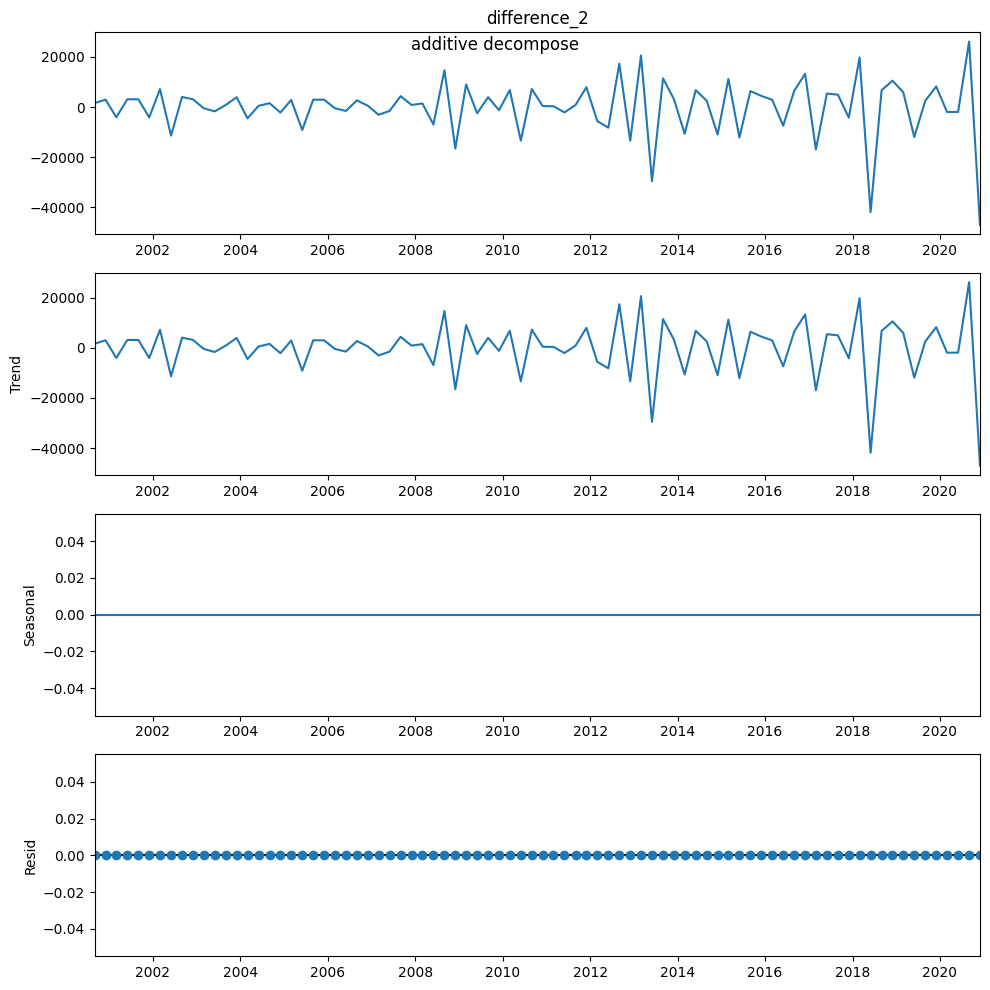

In [277]:
#Second order differencing
plotAll(df_clean, 'difference_2', 'CPI Over Time (log, d=1)', 'CPI', start_year, end_year+1, models='additive', periods=1)

### Model fitting, please fit a model according to the ACF and PACF plot

In [272]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels-tsa-arima-model-arimaresults
model = ARIMA(df_train, order=(2,2,0), seasonal_order=(0, 0, 0, 0))
#Using Maximum likelihood estimation
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                   84
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -888.482
Date:                Mon, 14 Nov 2022   AIC                           1782.963
Time:                        19:21:09   BIC                           1790.183
Sample:                    03-01-2000   HQIC                          1785.862
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9695      0.017    -57.642      0.000      -1.002      -0.937
ar.L2         -0.4753      0.013    -36.265      0.000      -0.501      -0.450
sigma2      6.111e+07    1.4e-10   4.37e+17      0.0

### Residual Analysis
#### Ljung-Box test for model adequacy

In [273]:
'''
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.test_serial_correlation.html
Ljung-Box test for serial correlation of standardized residuals (check the adequacy)
Null hypothesis is no serial correlation.
df_adjust: when true df = k-p-q
lags: default maxlag is min(10, number of observation//5), (lags is K)
'''
result = model_fit.test_serial_correlation(method='ljungbox',df_adjust=True, lags=10)
lgBoxResult(result)

At Lag: 0, Test statistic: 2.430202869732269, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 1, Test statistic: 3.6290556470181685, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 2, Test statistic: 4.660024895261794, p-value:0.03087274385040379
p-value =< 0.05, Null hypothesis is rejected, there is serial correlation.
------------------------------------------------------------------------------------------
At Lag: 3, Test statistic: 5.069799829913293, p-value:0.07926965257433666
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 4, Test statistic: 5.105971115193776, p-value

#### Standardized Residual: Sequence, Histogram, Q-Q plot, Correlogram, ACF, PACF

-------------------------------Shapiro-Wilk normality test Result------------------------------
Test statistic: 0.6550568342208862
p-value       : 9.555547542464127e-13
p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.
-----------------------------------------------------------------------------------------------
Figure(1000x1000)
Figure(1000x400)
Figure(1000x400)


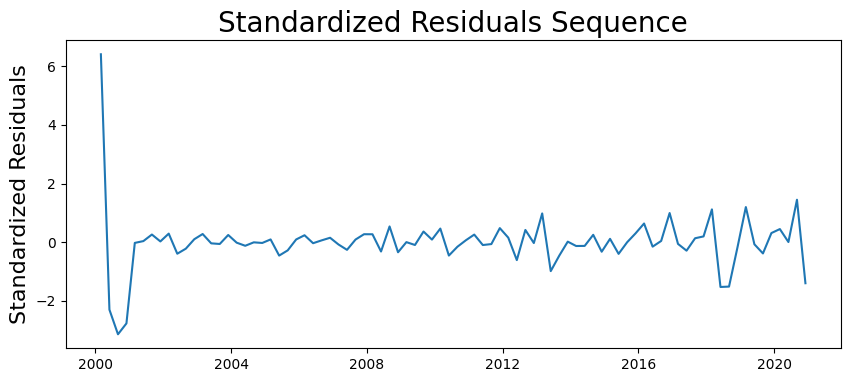

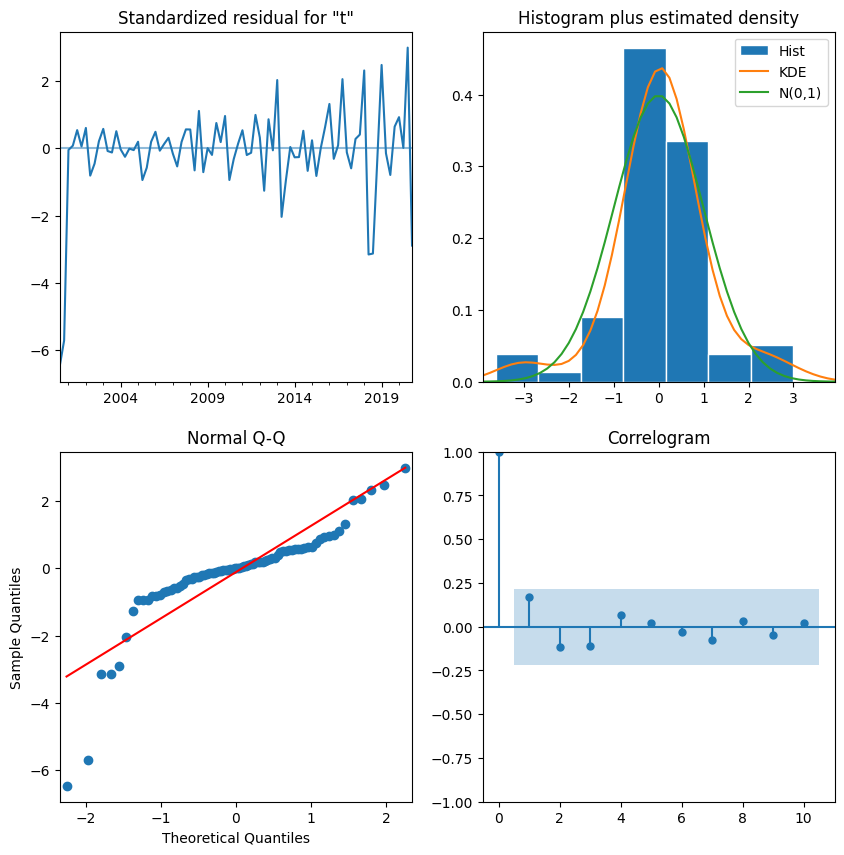

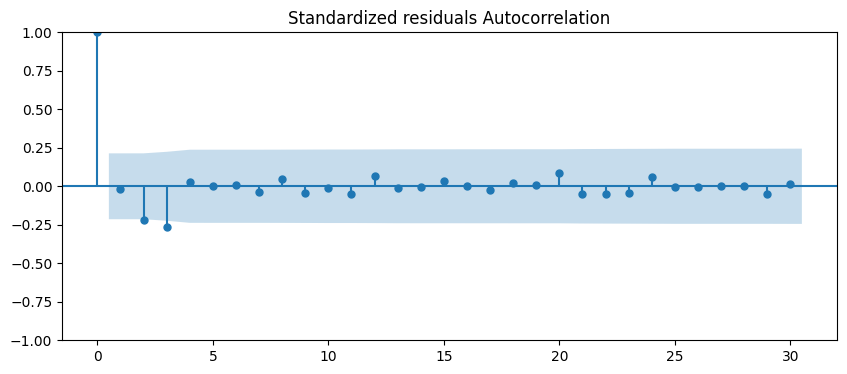

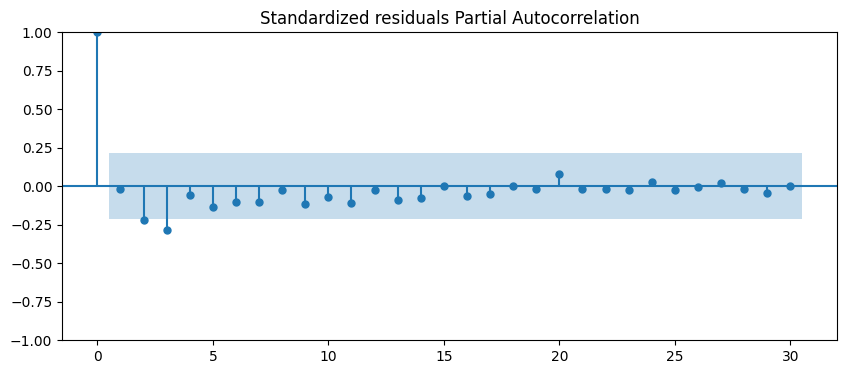

In [280]:
'''Test for normality of standardized residuals'''

#extract residuals sequence and calculate standardized residuals sequence
resid = model_fit.resid
std_resid = resid / resid.std()
plotStdResid(std_resid)

#The Jarque-Bera test of normality. (Not used)
model_fit.test_normality(method='jarquebera')

#Shapiro-Wilk normality test
#Null hypothesis: data was drawn from a normal distribution
shapiro_test(std_resid)

#Standardized residual sequence, Histogram, Q-Q plot, correlogram
print(model_fit.plot_diagnostics(figsize=(10,10)))

#ACF and PACF of the residuals
plt.rcParams.update({'figure.figsize':(10,4)})
print(plot_acf(std_resid,  alpha=.05, lags=30, title='Standardized residuals Autocorrelation'))
print(plot_pacf(std_resid,  alpha=.05, method='ywm',lags=30, title='Standardized residuals Partial Autocorrelation'))

In [ ]:
'''
Overparameterized method to check the adequacy
'''
